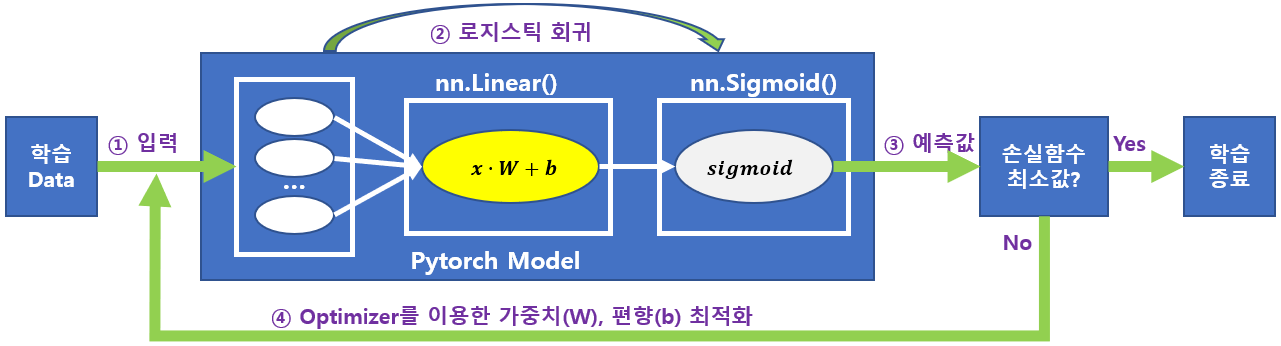

# 1.당뇨병 발생 여부 예측

## 1.1.학습 Data Load

In [ ]:
import pandas as pd

training_data = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/NeoWizard(박성호)-Pytorch/data/diabetes.csv',
    header=None
)

print(training_data.iloc[:,[8,]].value_counts(dropna=False, ascending=True), end='\n\n')
# Negative -500, Positive - 268
training_data.info()

8
0    263
1    496
Name: count, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       759 non-null    float64
 1   1       759 non-null    float64
 2   2       759 non-null    float64
 3   3       759 non-null    float64
 4   4       759 non-null    float64
 5   5       759 non-null    float64
 6   6       759 non-null    float64
 7   7       759 non-null    float64
 8   8       759 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 53.5 KB


## 1.2.학습 Data 정의

In [ ]:
import torch

# 입력과 정답의 분리
x_train_pd = training_data.iloc[:, :-1] # 모든 행, 처음부터 마지막 열 앞에 까지
t_train_pd = training_data.iloc[:, [-1]]  # 모든 행, 마지막 열 앞에 까지

print('================================================')
print(f'x_train_pd.shape = {x_train_pd.shape}')
print(x_train_pd[:5])
print('================================================')
print(f't_train_pd.shape = {t_train_pd.shape}')
print(t_train_pd[:5])

# pandas.DataFrame => Numpy.ndarray => Pytorch.Tensor
#               .values           .Tensor()
x_train = torch.FloatTensor(x_train_pd.values)
print('================================================')
print(f'x_train.size() = {x_train.size()}')
print(x_train[:5])
t_train = torch.FloatTensor(t_train_pd.values)
print('================================================')
print(f't_train.size() = {t_train.size()}')
print(t_train[:5])

x_train_pd.shape = (759, 8)
          0         1         2         3         4         5         6  \
0 -0.294118  0.487437  0.180328 -0.292929  0.000000  0.001490 -0.531170   
1 -0.882353 -0.145729  0.081967 -0.414141  0.000000 -0.207153 -0.766866   
2 -0.058824  0.839196  0.049180  0.000000  0.000000 -0.305514 -0.492741   
3 -0.882353 -0.105528  0.081967 -0.535354 -0.777778 -0.162444 -0.923997   
4  0.000000  0.376884 -0.344262 -0.292929 -0.602837  0.284650  0.887276   

          7  
0 -0.033333  
1 -0.666667  
2 -0.633333  
3  0.000000  
4 -0.600000  
t_train_pd.shape = (759, 1)
   8
0  0
1  1
2  0
3  1
4  0
x_train.size() = torch.Size([759, 8])
tensor([[-0.2941,  0.4874,  0.1803, -0.2929,  0.0000,  0.0015, -0.5312, -0.0333],
        [-0.8824, -0.1457,  0.0820, -0.4141,  0.0000, -0.2072, -0.7669, -0.6667],
        [-0.0588,  0.8392,  0.0492,  0.0000,  0.0000, -0.3055, -0.4927, -0.6333],
        [-0.8824, -0.1055,  0.0820, -0.5354, -0.7778, -0.1624, -0.9240,  0.0000],
        [ 0.0

## 1.3.Pytorch Logistic Regression Model 구축

In [ ]:
import torch.nn as nn

class LogisticRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.logistic = nn.Sequential(
        nn.Linear(8, 1),  # x·W + b 수행, 입력이 8개, 출력이 하나
        nn.Sigmoid()      # sigmoid 수행, 출력이 0 ~ 1 사이
    )
  def forward(self, x_data):
    prediction = self.logistic(x_data)
    return prediction

## 1.4.Model 생성, 손실함수, Optimizer 정의

In [ ]:
model = LogisticRegressionModel()  # model instance 생성

# model parameter 확인 - Weight 8개, Bias 1개를 확인할 수 있다.
for param in model.parameters():
  print(param)

# Logistic Regression이므로 손실함수는 Binary Cross Entropy를 사용
criterion = nn.BCELoss()
# Optimizer는 일반적인 확률적 경사하강법(SGD, Stochastic Gradient Descent)을 사용
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

Parameter containing:
tensor([[-0.2011,  0.1539, -0.3239, -0.3117,  0.3028, -0.1219,  0.1522, -0.1860]],
       requires_grad=True)
Parameter containing:
tensor([0.0082], requires_grad=True)


## 1.5.학습

In [ ]:
train_loss_list = []
train_accuracy_list = []
epochs = 5000
for epoch in range(epochs):
  model.train()   # training mode

  # model에 data를 전달하면, model의 forward()가 자동으로 실행
  # 직접 forward()를 호출하면 안됨
  output = model(x_train)

  # 오차 계산
  loss = criterion(output, t_train)

  train_loss_list.append(loss.item())

  # 정확도를 구한다.
  # output은 sigmoid 함수의 결과이므로, 0~1, 0.5 보다 크면 True, 작으면 False
  prediction = output > 0.5
  # prediction을 float으로 TypeCasting해서 정답(t)과 비교
  correct = (prediction.float() == t_train)
  # sum() - Tensor type 내의 모두 요소의 합을 반환
  # item() - Tensor type에서 값만 반환
  accuracy = correct.sum().item() / len(correct)
  train_accuracy_list.append(accuracy)

  # 오차 역전파(Back-propagation)
  optimizer.zero_grad() # 기울기 초기화
  loss.backward()       # 기울기 계산
  optimizer.step()      # 가중치 upgrade

  if epoch % 100 == 0:
    print(f'epoch=={epoch}, current loss={loss.item()}, accuracy={accuracy}')

print(f'epoch=={epoch}, final loss={loss.item()}, accuracy={accuracy}')

epoch==0, current loss=0.6839724183082581, accuracy=0.5652173913043478
epoch==100, current loss=0.5766124725341797, accuracy=0.6772068511198946
epoch==200, current loss=0.5431294441223145, accuracy=0.7193675889328063
epoch==300, current loss=0.5226572155952454, accuracy=0.7549407114624506
epoch==400, current loss=0.5093871355056763, accuracy=0.764163372859025
epoch==500, current loss=0.5003727078437805, accuracy=0.7707509881422925
epoch==600, current loss=0.4940199553966522, accuracy=0.7681159420289855
epoch==700, current loss=0.48941075801849365, accuracy=0.7760210803689065
epoch==800, current loss=0.485986590385437, accuracy=0.7654808959156785
epoch==900, current loss=0.4833919107913971, accuracy=0.7654808959156785
epoch==1000, current loss=0.4813922345638275, accuracy=0.766798418972332
epoch==1100, current loss=0.47982800006866455, accuracy=0.7681159420289855
epoch==1200, current loss=0.47858792543411255, accuracy=0.7681159420289855
epoch==1300, current loss=0.4775925874710083, accu

In [ ]:
for name, child in model.named_children():
  for param in child.parameters():
    print(name, param)

for param in model.parameters():
    print(param)

## 1.6 시각화

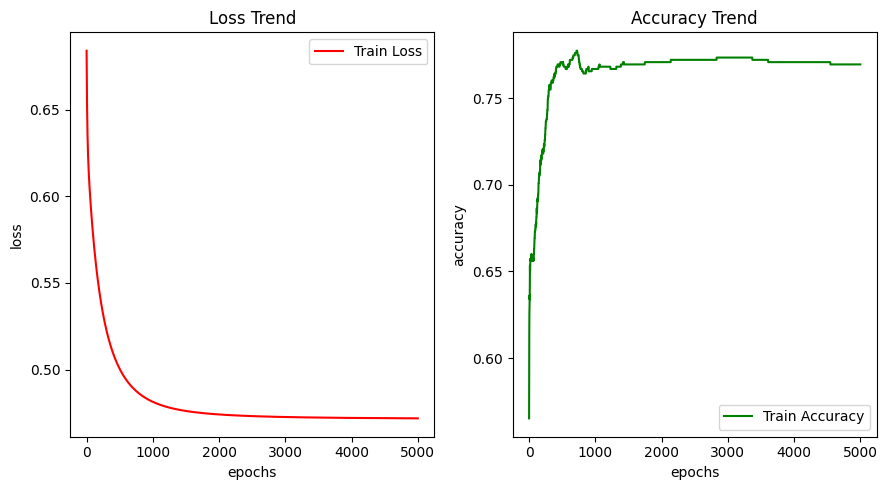

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)                # nrows=1, ncols=2, index=1
plt.plot(train_loss_list, color='red', label='Train Loss')
plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)                # nrows=1, ncols=2, index=2
plt.plot(train_accuracy_list, color='green', label='Train Accuracy')
plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# 2.대학원 합격 여부 예측

 - GRE(Graduate Record Examination), GPA(Grade Point Average), 성적 그리고 Rank(University Rating)에 대한 대학원 합격/불합격 정보

## 1.1.학습 Data Load

In [ ]:
import pandas as pd

training_data = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/NeoWizard(박성호)-Pytorch/data/admission.csv'
)

training_data.info()
print(training_data.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   admit   400 non-null    int64  
 1   gre     400 non-null    int64  
 2   gpa     400 non-null    float64
 3   rank    400 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 12.6 KB
   admit  gre   gpa  rank
0      0  380  3.61     3
1      1  660  3.67     3
2      1  800  4.00     1


## 1.2.학습 Data 정의

In [ ]:
from sklearn.preprocessing import MinMaxScaler # 데이터 정규화를 위해
import torch

# 1. 결측치 처리
training_data.isnull().sum(axis=0)

# 2. 이상치 처리 - 생략
#    zscore, tukey's funce

# 입력과 정답의 분리
x_train_pd = training_data.iloc[:, 1:] # 모든 행, 1열부터 마지막 열 앞에 까지
t_train_pd = training_data.iloc[:, [0]]  # 모든 행, 0열만

print('================================================')
print(f'type(x_train_pd) = {type(x_train_pd)}')
print(f'x_train_pd.shape = {x_train_pd.shape}')
print(x_train_pd[:5])
print('================================================')
print(f'type(t_train_pd) = {type(t_train_pd)}')
print(f't_train_pd.shape = {t_train_pd.shape}')
print(t_train_pd[:5])

# 3. Normalization(정규화)
scaler = MinMaxScaler()
scaler.fit(x_train_pd.values) # numpy로 MinMaxScaler() 학습
x_train_norm = scaler.transform(x_train_pd.values) # numpy로 MinMaxScaler() 적용
print('================================================')
print(f'type(x_train_norm) = {type(x_train_norm)}')
print(f'x_train_norm.shape = {x_train_norm.shape}')
print(x_train_norm[:5])
print(type(x_train_norm))

# pandas.DataFrame => Numpy.ndarray => Pytorch.Tensor
#               .values           .Tensor()
x_train = torch.FloatTensor(x_train_norm)
print('================================================')
print(f'type(x_train) = {type(x_train)}')
print(f'x_train.size() = {x_train.size()}')
print(x_train[:5])
t_train = torch.FloatTensor(t_train_pd.values.reshape(-1, 1))
print('================================================')
print(f'type(t_train) = {type(t_train)}')
print(f't_train.size() = {t_train.size()}')
print(t_train[:5])

type(x_train_pd) = <class 'pandas.core.frame.DataFrame'>
x_train_pd.shape = (400, 3)
   gre   gpa  rank
0  380  3.61     3
1  660  3.67     3
2  800  4.00     1
3  640  3.19     4
4  520  2.93     4
type(t_train_pd) = <class 'pandas.core.frame.DataFrame'>
t_train_pd.shape = (400, 1)
   admit
0      0
1      1
2      1
3      1
4      0
type(x_train_norm) = <class 'numpy.ndarray'>
x_train_norm.shape = (400, 3)
[[0.27586207 0.77586207 0.66666667]
 [0.75862069 0.81034483 0.66666667]
 [1.         1.         0.        ]
 [0.72413793 0.53448276 1.        ]
 [0.51724138 0.38505747 1.        ]]
<class 'numpy.ndarray'>
type(x_train) = <class 'torch.Tensor'>
x_train.size() = torch.Size([400, 3])
tensor([[0.2759, 0.7759, 0.6667],
        [0.7586, 0.8103, 0.6667],
        [1.0000, 1.0000, 0.0000],
        [0.7241, 0.5345, 1.0000],
        [0.5172, 0.3851, 1.0000]])
type(t_train) = <class 'torch.Tensor'>
t_train.size() = torch.Size([400, 1])
tensor([[0.],
        [1.],
        [1.],
        [1.],
 

## 1.3 Model 정의

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class LogisticRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.logistic = nn.Linear(3, 1)
  def forward(self, xData):
    return torch.sigmoid(self.logistic(xData))

## 1.4.Model 생성, 손실함수, Optimizer 정의

In [ ]:
model = LogisticRegressionModel()

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr= 1e-4)

## 1.5.학습

In [ ]:
loss_list = []
epochs = 500
for epoch in range(epochs):
  model.train() # 학습 mode
  prediction = model(x_train) # 예측

  loss = criterion(prediction, t_train) # loss 계산
  loss_list.append(loss.item())

  # 오차 역전파(Back-propagation)
  optimizer.zero_grad() # 기울기 초기화
  loss.backward()       # 기울기 계산
  optimizer.step()      # 가중치 upgrade

  if epoch % 100 == 0:
    print(f'epoch= {epoch}, current loss= {loss.item()}')

print(f'epoch= {epoch}, final loss= {loss.item()}')

epoch= 0, current loss= 0.6653870940208435
epoch= 100, current loss= 0.6649758219718933
epoch= 200, current loss= 0.6645685434341431
epoch= 300, current loss= 0.6641654372215271
epoch= 400, current loss= 0.6637662649154663
epoch= 499, final loss= 0.6633748412132263


## 1.6.시각화

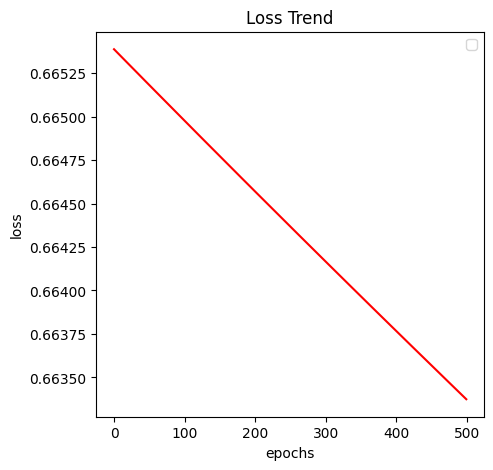

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')

plt.plot(loss_list, color='red', label='Train Loss')
plt.show()

## 1.6.평가

In [ ]:
import numpy as np

model.eval() # 평가 mode

# 1차원 array의 경우 reshape(-1, 1)을 이용 shape을 변경
x_score = np.array([700, 4.3, 1]).reshape(-1,3)
#x_score = np.array([600, 3.67, 3]).reshape(-1,3)
x_score_norm = scaler.transform(x_score) # numpy로 MinMaxScaler() 적용
x_input = torch.FloatTensor(x_score_norm)

result = model(x_input).item()
print(result)

0.47377750277519226
